In [ ]:
import numpy as np
import pandas as pd
import catboost as cat
import xgboost as xgb
import lightgbm as lgb
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn import preprocessing
import shap


In [256]:
datasets_path = glob.glob(r'..\data\*.csv')

csv_files = {
    path.split("\\")[-1][:-4]: path
    for path in datasets_path
}

df = pd.read_csv(csv_files['dehliclimate'])
df['date'] = pd.to_datetime(df['date'])
remove_train = ['date','meantemp']
val_size = len(df) - 50

In [290]:
df['humidity_lag2'] = df['humidity'].shift(2)
df['humidity_lag4'] = df['humidity'].shift(4)
df['humi_rolling_mean_4'] = df['humidity'].rolling(4).mean()
df['wind_speed_lag2'] = df['wind_speed'].shift(2)
df['meanpressure_mean_4'] = df['meanpressure'].rolling(4).mean()
df = df.fillna(0)
features = list(df.drop(columns=remove_train).columns)

x_train_raw = df[features][:val_size]
y_train = df['meantemp'][:val_size]
x_val_raw = df[features][val_size:]
y_val = df['meantemp'][val_size:].reset_index(drop=True)

scaler = preprocessing.StandardScaler().fit(x_train_raw)


x_train= scaler.transform(x_train_raw)
x_val = scaler.transform(x_val_raw)

print(features)

['humidity', 'wind_speed', 'meanpressure', 'humidity_lag2', 'humi_rolling_mean_4', 'wind_speed_lag2', 'wind_rolling_mean_4', 'humidity_lag4', 'wind_speed_lag4', 'meanpressure_mean_4']


## Data Pearson Correlations Exploration :
Looking for using better columns for the lag features 

In [284]:
print(f"Humidity: {np.round((df['meantemp'].corr(df['humidity'],method='pearson') * 100),2)}%")
print(f"Mean Pressure: {np.round((df['meantemp'].corr(df['meanpressure'],method='pearson') * 100),2)}%")
print(f"Wind: {np.round((df['meantemp'].corr(df['wind_speed'],method='pearson') * 100),2)}%")

Humidity: -57.2%
Mean Pressure: -3.88%
Wind: 30.65%


In [291]:
evaldata = cat.Pool(x_val ,y_val)
model_cat = cat.CatBoostRegressor(iterations= 5000 
                              ,task_type = "CPU"	
                              ,learning_rate=0.001
                              ,depth=3
                              ,verbose=0 
                              ,loss_function='RMSE')


model_lgbm = lgb.LGBMRegressor(n_estimators = 5000
                        ,learning_rate = 0.001
                        ,objective='regression'
                        ,max_depth=5
                        ,early_stopping_rounds=50
                        ,metric='rmse'
                        ,verbose=-1)

model_xgb = xgb.XGBRegressor(n_estimators = 5000
                         ,learning_rate = 0.001
                         ,eval_metric='rmse'
                         ,early_stopping_rounds= 50)



model_lgbm.fit(x_train, y_train , eval_set=[(x_val, y_val)])
model_xgb.fit(x_train,y_train,  eval_set=[(x_val, y_val)],verbose=1000)
model_cat.fit(x_train, y_train, eval_set=[evaldata], early_stopping_rounds=100)

y_pred_cat = model_cat.predict(x_val)
y_pred_xgb = model_xgb.predict(x_val)
y_pred_lgbm = model_lgbm.predict(x_val)

rmse_cat = np.sqrt(mean_squared_error(y_val, y_pred_cat))
rmse_xgb = root_mean_squared_error(y_val, y_pred_xgb)
rmse_lgbm = root_mean_squared_error(y_val,y_pred_lgbm)

[0]	validation_0-rmse:7.18026
[1000]	validation_0-rmse:3.54406
[1935]	validation_0-rmse:3.02530


### Model Feature impact lookup

In [304]:
shap.initjs()

x_val_df = pd.DataFrame(x_val, columns=features)
explainer = shap.Explainer(model_xgb)
shap_values = explainer(x_val_df)
shap.force_plot(shap_values, x_val_df)
#shap.plots.beeswarm(shap_values)

## Results of the Validation Dataset (Not Pre-seeded by the Model):

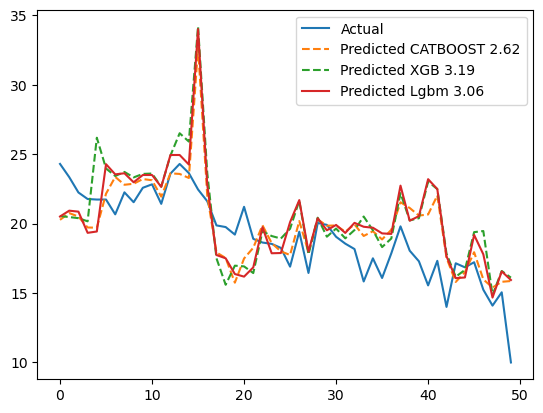

In [275]:
plt.plot(y_val, label = "Actual")
plt.plot(y_pred_cat, label = f"Predicted CATBOOST {np.round(rmse_cat,2)}",linestyle='--')
plt.plot(y_pred_xgb, label = f"Predicted XGB {np.round(rmse_xgb,2)}",linestyle='--', )
plt.plot(y_pred_lgbm, label = f"Predicted Lgbm {np.round(rmse_lgbm,2)}")
plt.legend()

## Applying The Model Prediction For All Date Range

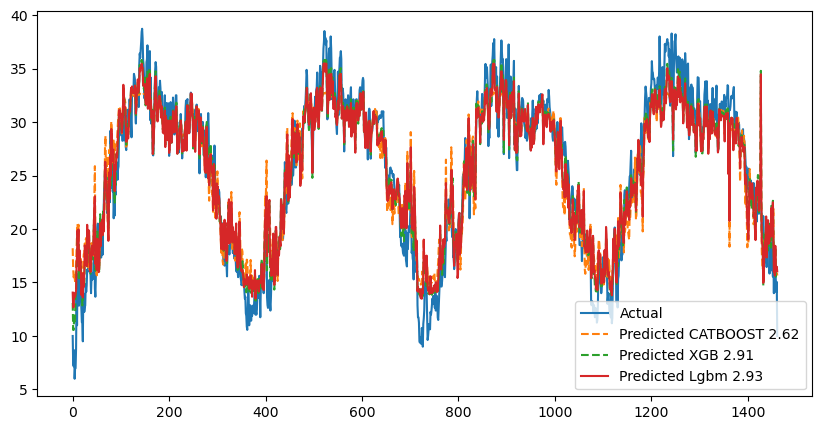

In [169]:
ya_pred_cat = model_cat.predict(df[features])
ya_pred_xgb = model_xgb.predict(df[features])
ya_pred_lgbm = model_lgbm.predict(df[features])

rmsea_cat = np.sqrt(mean_squared_error(y_val, y_pred_cat))
rmsea_xgb = root_mean_squared_error(y_val, y_pred_xgb)
rmsea_lgbm = root_mean_squared_error(y_val,y_pred_lgbm)

fig = plt.figure(figsize=(10,5))
plt.plot(df['meantemp'], label = "Actual")
plt.plot(ya_pred_cat, label = f"Predicted CATBOOST {np.round(rmsea_cat,2)}",linestyle='--')
plt.plot(ya_pred_xgb, label = f"Predicted XGB {np.round(rmsea_xgb,2)}",linestyle='--', )
plt.plot(ya_pred_lgbm, label = f"Predicted Lgbm {np.round(rmsea_lgbm,2)}")
plt.legend()